In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


# Plotting F0, amplitude and duration along the mel spectrogram and all the dimensions of prosody encoding 

## 1. Computing F0 from an audio file.

In [2]:
import numpy as np
from PIL import Image
from data_utils import TextMelLoader
from hparams import create_hparams
from utils import load_wav_to_torch

hparams = create_hparams()
valset = TextMelLoader(hparams, 'val')
wav_path = '/data2/sungjaecho/data_tts/EmoV-DB/EmoV-DB/bea/angry/angry_0001.wav'
wav, sr = load_wav_to_torch(wav_path)
melspec = valset.get_mel(wav_path)
spectrogram = melspec.numpy()
print("Sample rate:", sr)
print("wav.shape:", wav.shape)
print("melspec.size()", melspec.size())
print("melspec.type()", melspec.type())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Sample rate: 22050
wav.shape: torch.Size([80704])
melspec.size() torch.Size([80, 316])
melspec.type() torch.FloatTensor


In [3]:
from yin import compute_yin

def get_f0(wav, sampling_rate=22050, frame_length=1024,
               hop_length=256, f0_min=100, f0_max=300, harm_thresh=0.1):
    f0, harmonic_rates, argmins, times = compute_yin(
        wav, sampling_rate, frame_length, hop_length, f0_min, f0_max,
        harm_thresh)
    pad = int((frame_length / hop_length) / 2)
    f0 = [0.0] * pad + f0 + [0.0] * pad

    f0 = np.array(f0, dtype=np.float32)
    return f0

### 1.1. Procedure to compute F0

In [4]:
hparams = create_hparams()
wav_path = '/data2/sungjaecho/data_tts/EmoV-DB/EmoV-DB/bea/angry/angry_0001.wav'
wav, sr = load_wav_to_torch(wav_path)
f0 = get_f0(wav.cpu().numpy(), hparams.sampling_rate,
            hparams.filter_length, hparams.hop_length, hparams.f0_min,
            hparams.f0_max, hparams.harm_thresh)
f0 = f0[:melspec.size(1)]

In [5]:
print(f0.shape)

(316,)


The length of `f0` is the same as that of `melspec`.

## 2. Amplitude

I have learned how to compute amplitude from [this page](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0).

## 3. Duration

In [6]:
from text import text_to_sequence, sequence_to_text_list

text_string = "I will use the sum of amplitude across frequency at the time step."

i_seq = text_to_sequence(text_string, hparams.text_cleaners, valset.get_g2p_dictionary())
text_seq = sequence_to_text_list(i_seq)

In [7]:
print(i_seq)
print(text_seq)
print(len(i_seq))
print(len(text_seq))

[46, 11, 60, 46, 49, 49, 11, 58, 56, 42, 11, 57, 45, 42, 11, 56, 58, 50, 11, 52, 43, 11, 38, 50, 53, 49, 46, 57, 58, 41, 42, 11, 38, 40, 55, 52, 56, 56, 11, 43, 55, 42, 54, 58, 42, 51, 40, 62, 11, 38, 57, 11, 57, 45, 42, 11, 57, 46, 50, 42, 11, 56, 57, 42, 53, 7]
['i', ' ', 'w', 'i', 'l', 'l', ' ', 'u', 's', 'e', ' ', 't', 'h', 'e', ' ', 's', 'u', 'm', ' ', 'o', 'f', ' ', 'a', 'm', 'p', 'l', 'i', 't', 'u', 'd', 'e', ' ', 'a', 'c', 'r', 'o', 's', 's', ' ', 'f', 'r', 'e', 'q', 'u', 'e', 'n', 'c', 'y', ' ', 'a', 't', ' ', 't', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 's', 't', 'e', 'p', '.']
66
66


In [8]:
text_steps = len(text_seq)
mel_steps = 640
alignment = np.zeros((mel_steps, text_steps))
gradient = (text_steps / mel_steps)
for i in range(mel_steps):
    alignment[i, int(gradient * i)] = 1


In [9]:
attended_text_loc = alignment.argmax(axis=1)
print(attended_text_loc.shape)

(640,)


In [10]:
import matplotlib.pyplot as plt

mel_step = np.arange(mel_steps)
plt.plot(mel_step, attended_text_loc)
cnt = 0
prev_y = -1
for i in range(mel_steps):
    x = mel_step[i]
    y = attended_text_loc[i]
    if y != prev_y:
        prev_y = y
        cnt += 1
        plt.text(x, y+5, text_seq[y])

print("{} transitions".format(cnt))
        
plt.show()

66 transitions


<Figure size 640x480 with 1 Axes>

In [11]:
(mel_steps, text_steps) = alignment.shape
y = attended_text_loc = alignment.argmax(axis=1)

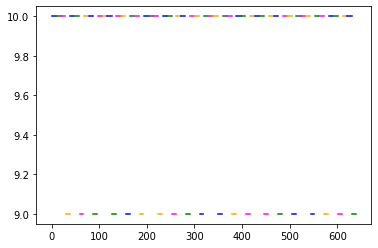

In [12]:
x = np.arange(mel_steps)
colors = ['orange', 'blue', 'green', 'magenta']

prev_yi = -1
i_color = 0
for i in range( mel_steps):
    xi = x[i]
    yi = y[i]
    if i > 0:
        prev_yi = y[i-1]
    if i < mel_steps -1:
        next_yi = y[i+1]

    if (prev_yi != yi) or (i == 0):
        start = True
    else:
        start = False

    if (next_yi != yi) or (i == mel_steps - 1):
        end = True
    else:
        end = False

    if start:
        xi_list = list()

    xi_list.append(xi)

    if end:  
        yi_list = y[xi_list[0]:xi_list[-1]+1]        
        i_color += 1
        duration = len(xi_list)
        #plt.plot(xi_list, yi_list, '-', color=colors[i_color % len(colors)])
        plt.plot(xi_list, [duration]*len(xi_list), '-', color=colors[i_color % len(colors)])
        #plt.text(xi_list[-1], duration+1, "{}".format(text_seq[yi]))

# **Restart the kernel!!!**

## 4. Funcitonalize plotting

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


In [2]:
from yin import compute_yin

def get_f0(wav, sampling_rate=22050, frame_length=1024,
               hop_length=256, f0_min=100, f0_max=300, harm_thresh=0.1):
    f0, harmonic_rates, argmins, times = compute_yin(
        wav, sampling_rate, frame_length, hop_length, f0_min, f0_max,
        harm_thresh)
    pad = int((frame_length / hop_length) / 2)
    f0 = [0.0] * pad + f0 + [0.0] * pad

    f0 = np.array(f0, dtype=np.float32)
    return f0

In [3]:
def get_text_durations(alignment):
    '''
    Params
    -----
    alignment: A stack of attention weights at every decoding step.
    - type: numpy.ndarray.
    - dtype: float.
    - shape: (mel_steps, text_steps)
    
    Returns
    -----
    text_durations: # Mel frames where a grapheme/phoneme is continuously spoken.
    - type: list.
    - dtype: int.
    x_chunks: A list of chunks containing mel steps where a grapheme/phoneme is continuously spoken.
    - type: list.
    - dtype: list. that contains integers.
    att_text_seq: A sequence of maximally attended text.
    - type: list.
    - dtype: int.
    '''
    (mel_steps, text_steps) = alignment.shape
    text_durations = list()
    x_chunks = list()
    # y cantains maximally attended text locations.
    x = list(range(mel_steps))
    att_text_seq = y = alignment.argmax(axis=1)
    prev_yi = -1
    for i in range(mel_steps):
        xi = x[i]
        yi = y[i]
        if i > 0:
            prev_yi = y[i-1]
        if i < mel_steps -1:
            next_yi = y[i+1]

        if (prev_yi != yi) or (i == 0):
            start = True
        else:
            start = False

        if (next_yi != yi) or (i == mel_steps - 1):
            end = True
        else:
            end = False

        if start:
            xi_list = list()

        xi_list.append(xi)
        
        if end:  
            yi_list = y[xi_list[0]:xi_list[-1]+1]        
            duration = len(xi_list)
            text_durations += [duration]*len(xi_list)
            x_chunks.append(xi_list)
            
    return text_durations, x_chunks, att_text_seq

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from plotting_utils import save_figure_to_numpy

def plot_prosody_dims_to_numpy(spectrogram, wav, text_seq, alignment, prosody, hparams):
    '''
    PARAMS
    -----
    spectrogram: Mel Spectrogram of speech.
    - type: numpy.ndarray.
    - shape: (frames, n_mel_channels)
    : A wav sequence of speech.
    - type: numpy.ndarray.
    - shape: (sample_len,)
    text_seq: A list of graphemes or phonemes.
    - type: list.
    - dtype: str.
    alignment: A stack of attention weights at every decoding step.
    - type: numpy.ndarray.
    - dtype: float.
    - shape: (mel_steps, text_steps)
    prosody: A pack of prosody encodings at speech spectrogram frames.
    - type: numpy.ndarry. 
    - shape: (frames, prosody_dim)
    sr: The sample rate of the wav.
    - type: int.
    
    RETURNS
    -----
    data: An image in the format of NumPy.
    - type: numpy.ndarray
    '''
    n_decoding_steps = prosody.shape[0]
    n_prosody_dims = prosody.shape[1]
    
    n_leading_figures = 4
    n_figures = n_leading_figures + n_prosody_dims
    fig, axes = plt.subplots(n_figures, 1, figsize=(12, 2*n_figures))
    
    x = np.arange(n_decoding_steps)
    colors = ['orange', 'blue', 'green', 'magenta']
    
    # [1] First figure: Spectrogram
    spectrogram = spectrogram.astype(np.float32) # casting required when fp16_run.
    axes[0].set_xlabel("Frames")
    axes[0].set_ylabel("Channels")
    im = axes[0].imshow(spectrogram, aspect="auto", origin="lower",
               interpolation='none')
    
    # [2] Second figure: F0
    wav = wav.astype(np.float32) # casting required when fp16_run.
    f0 = get_f0(wav, hparams.sampling_rate,
            hparams.filter_length, hparams.hop_length, hparams.f0_min,
            hparams.f0_max, hparams.harm_thresh)
    f0 = f0[:n_decoding_steps]
    axes[1].set_xlabel("Frames")
    axes[1].set_ylabel("F0 (Hz)")
    axes[1].set_xlim(x[0], x[-1])
    axes[1].set_ylim(hparams.f0_min, f0.max())
    axes[1].plot(x, f0)
    
    # [3] Third figure: Amplitude
    # Learned from https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    D = np.abs(
            librosa.core.stft(wav, 
                n_fft=hparams.filter_length, 
                hop_length=hparams.hop_length, 
                win_length=hparams.win_length))
    D = D[:,:n_decoding_steps]
    axes[2].set_xlabel("Frames")
    axes[2].set_ylabel("Amplitude (ΣSTFT(f))")
    axes[2].set_xlim(x[0], x[-1])
    axes[2].plot(x, D.sum(axis=0))
    
    # [4] Fourth figure: Duration
    durations, x_chunks, att_text_seq = get_text_durations(alignment)
    axes[3].set_xlabel("Frames")
    axes[3].set_ylabel("Duration (frames)")
    axes[3].set_xlim(x[0], x[-1])
    axes[3].set_ylim(0, max(durations)+1)
    i_color = 0
    for x_chunk in x_chunks:
        x_start = x_chunk[0]
        x_last = x_chunk[-1]
        duration = durations[x_start]
        int_att_text = att_text_seq[x_start]
        att_text = text_seq[int_att_text]
        axes[3].plot(x_chunk, durations[x_start:x_last+1], '-', color=colors[i_color % len(colors)])
        axes[3].text(x_start, duration, "{}".format(att_text))
        i_color += 1
       
            
    # [5] The rest of figures: Prosody dimensions.
    for i_dim in range(n_prosody_dims):
        prosody_dim = prosody[:,i_dim]
        prosody_dim = prosody_dim.astype(np.float32) # casting required when fp16_run.
        axes[i_dim+n_leading_figures].plot(x, prosody_dim, '-', color=colors[i_dim % len(colors)])
        axes[i_dim+n_leading_figures].set_xlabel("Decoding_step")
        axes[i_dim+n_leading_figures].set_ylabel("Prosody_dim{}".format(i_dim))
        axes[i_dim+n_leading_figures].set_xlim(x[0], x[-1])
        axes[i_dim+n_leading_figures].set_ylim(0, prosody_dim.max())
        
    # [6] Convert figures to an image
    plt.tight_layout()
    fig.canvas.draw()
    data = save_figure_to_numpy(fig)
    plt.close()
    
    return data

## 6. Test the function

In [5]:
import numpy as np
from PIL import Image
from data_utils import TextMelLoader
from hparams import create_hparams
from utils import load_wav_to_torch

hparams = create_hparams()
valset = TextMelLoader(hparams, 'val')
wav_path = '/data2/sungjaecho/data_tts/EmoV-DB/EmoV-DB/bea/angry/angry_0001.wav'
wav, sr = load_wav_to_torch(wav_path)
wav = wav.cpu().numpy()
melspec = valset.get_mel(wav_path)
spectrogram = melspec.numpy()
print("Sample rate:", sr)
print("wav.shape:", wav.shape)
print("melspec.size()", melspec.size())
print("melspec.type()", melspec.type())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Sample rate: 22050
wav.shape: (80704,)
melspec.size() torch.Size([80, 316])
melspec.type() torch.FloatTensor


In [6]:
from text import text_to_sequence, sequence_to_text_list

text_string = "Author of the danger trail, Philip Steels, etc."

i_seq = text_to_sequence(text_string, hparams.text_cleaners, valset.get_g2p_dictionary())
text_seq = sequence_to_text_list(i_seq)

In [7]:
text_steps = len(text_seq)
mel_steps = melspec.size(1)
alignment = np.zeros((mel_steps, text_steps))
gradient = (text_steps / mel_steps)
for i in range(mel_steps):
    alignment[i, int(gradient * i)] = 1

In [8]:
xx = np.arange(0, melspec.size(1))
prosody_dim = np.cos(xx) + 1
prosody = np.stack([prosody_dim] * 4)
prosody = prosody.T
print(prosody.shape)

(316, 4)


In [9]:
import IPython.display as ipd
ipd.Audio(wav_path) # load a local WAV file

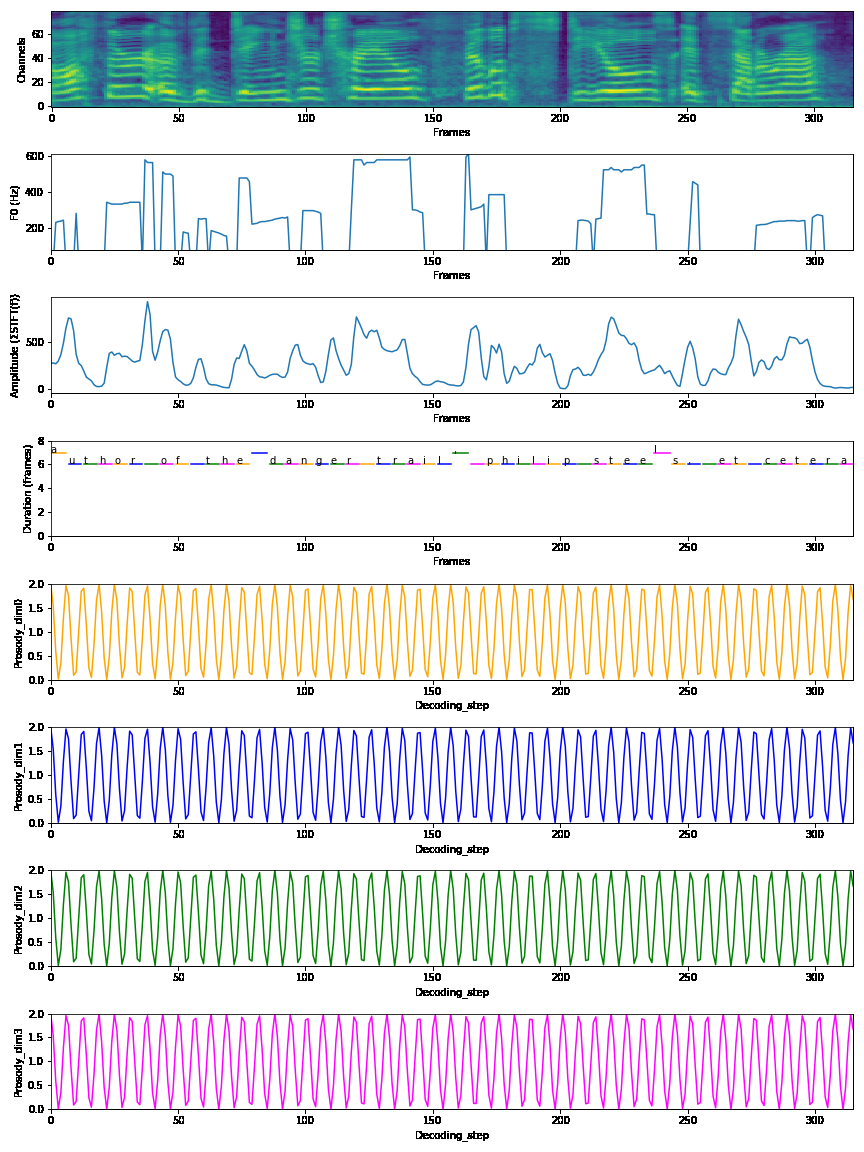

In [10]:
data = plot_prosody_dims_to_numpy(spectrogram, wav, text_seq, alignment, prosody, hparams)
Image.fromarray(data, 'RGB')